In [83]:
import numpy as np
import math
import random as random
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [85]:
# !pip install graphviz
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edges in agraph
    nodes,edges =set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges


def draw_dot(root):
    dot = Digraph(format='svg' ,graph_attr={'rankdir':"LR"}) #left to right

    nodes,edges =trace(root)
    for n in nodes:
        uid =str(id(n))
        #for any value in the graph ,create a rectangular('record) node for it
        dot.node(name=uid ,label ="{%s | data % 0.4f |grad % 0.4f}" %(n.label , n.data, n.grad),shape='record')
        if n._op:
            #if this value is a result of some operation,create an op node for it
            dot.node(name = uid + n._op ,label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1,n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)) ,str(id(n2)) +n2._op)

    return dot



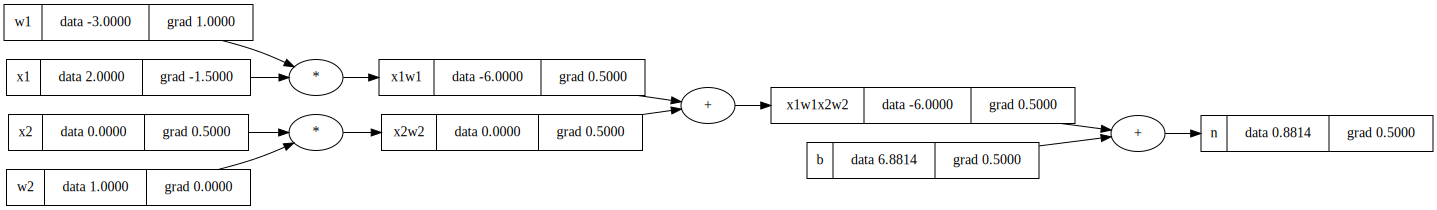

In [86]:
#Neural network inputs x1,x2
x1 =Value(2.0 ,label='x1')
x2 =Value( 0.0,label='x2')
#weights w1 w2
w1 =Value( -3.0,label='w1')
w2 =Value( 1.0,label='w2')
#bias of the neuron b
b= Value(6.8813735870195432 ,label='b')
x1w1 =x1*w1 ; x1w1.label ='x1w1'
x2w2 =x2*w2 ;x2w2.label ='x2w2'
x1w1x2w2 =x2w2 + x1w1 ; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b ; n.label='n'
o =n.tanh() ; o.label='o'
o.backward()
draw_dot(n)

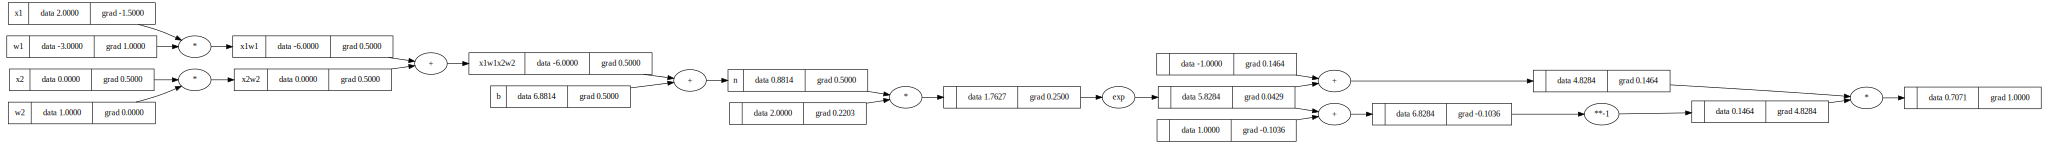

In [87]:
#Neural network inputs x1,x2
x1 =Value(2.0 ,label='x1')
x2 =Value( 0.0,label='x2')
#weights w1 w2
w1 =Value( -3.0,label='w1')
w2 =Value( 1.0,label='w2')
#bias of the neuron b
b= Value(6.8813735870195432 ,label='b')
x1w1 =x1*w1 ; x1w1.label ='x1w1'
x2w2 =x2*w2 ;x2w2.label ='x2w2'
x1w1x2w2 =x2w2 + x1w1 ; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b ; n.label='n'
e =(2*n).exp()
o =(e-1)/(e+1)
o.backward()
draw_dot(o)

In [88]:
# import torch
# x1 = torch.tensor([2.0]).double()           ;x1.requires_grad=True
# x2 = torch.tensor([0.0]).double()           ;x2.requires_grad=True
# w1 = torch.tensor([-3.0]).double()           ;w1.requires_grad=True
# w2 = torch.tensor([1.0]).double()           ;w2.requires_grad=True
# b = torch.tensor([6.8813735870195432]).double()           ;b.requires_grad=True
# n=x1*w1 +x2*w2 +b
# o=torch.tanh(n)
# print(o.data.item())
# o.backward()

# print('---')
# print('x2',x2.grad.item())
# print('w2',w2.grad.item())
# print('x1',x1.grad.item())
# print('w1',w1.grad.item())

In [89]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [90]:
x=[2.0,3.0,-1.0]
# n=Neuron(2)
# y=Layer(2,3)
# print(y(x))
# n(x)
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.30714074843333267)

In [91]:
n.parameters()

[Value(data=-0.17922405648342798),
 Value(data=-0.07427000799389849),
 Value(data=-0.41668037552689463),
 Value(data=0.5379753605080737),
 Value(data=0.7513009413663856),
 Value(data=0.7385650347882649),
 Value(data=0.038920473245733334),
 Value(data=-0.47135452829668756),
 Value(data=-0.6607509554545707),
 Value(data=-0.8292718613310088),
 Value(data=0.8180736753205968),
 Value(data=0.660044812152617),
 Value(data=0.3653824322509629),
 Value(data=-0.6472905362925576),
 Value(data=-0.17789174502057503),
 Value(data=-0.6708199732728415),
 Value(data=-0.01490901616052942),
 Value(data=0.026173554102482566),
 Value(data=-0.5457001367194181),
 Value(data=0.19875906348401196),
 Value(data=-0.5199523099786583),
 Value(data=0.1311836135613007),
 Value(data=0.7239310495352165),
 Value(data=0.933662570828786),
 Value(data=0.225788561055684),
 Value(data=-0.29498815817787905),
 Value(data=-0.545069688239862),
 Value(data=-0.3793937212656031),
 Value(data=0.3045748712063374),
 Value(data=-0.02749

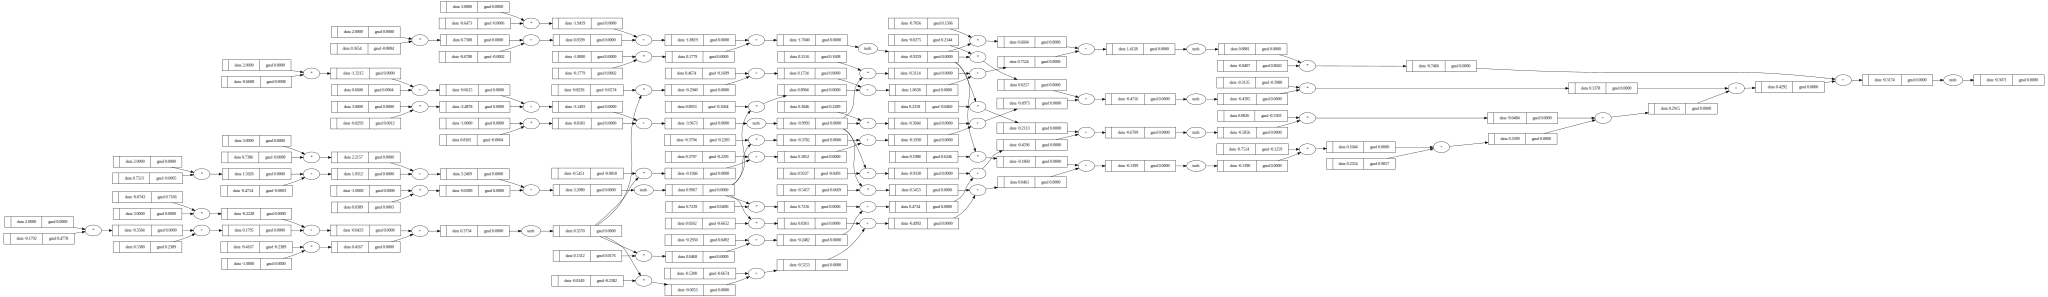

In [92]:
n(x).backward()
draw_dot(n(x))

In [98]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
# n.layers[0].neurons[0].w[0].grad
# ypred = [n(x) for x in xs]
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# loss

In [100]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
#   print(k, loss.data)

In [101]:
ypred

[Value(data=0.9641628944986765),
 Value(data=-0.9779760826636178),
 Value(data=-0.9425316226226725),
 Value(data=0.9725589619191325)]